In [1]:
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from einops import rearrange, repeat
from scipy.linalg import sqrtm
from scipy import integrate

In [2]:
def to_flattened_numpy(x):
  """Flatten a torch tensor `x` and convert it to numpy."""
  return x.detach().cpu().numpy().reshape((-1,))

def from_flattened_numpy(x, shape):
  """Form a torch tensor with the given `shape` from a flattened numpy array `x`."""
  return torch.from_numpy(x.reshape(shape))

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.embed_dim = embed_dim
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    #print('t embed: ', x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

  def __len__(self):
    return self.embed_dim

class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = torch.tensor(self.size // 2, device=x.device)
        emb = torch.log(torch.tensor([10000.0], device=x.device)) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size, device=x.device))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size

class LinearEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x / self.size * self.scale
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class LearnableEmbedding(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.size = size
        self.linear = nn.Linear(1, size)

    def forward(self, x: torch.Tensor):
        return self.linear(x.unsqueeze(-1).float() / self.size)

    def __len__(self):
        return self.size

class IdentityEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1)

    def __len__(self):
        return 1

class ZeroEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1) * 0

    def __len__(self):
        return 1

class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, type: str, **kwargs):
        super().__init__()
        if type == "sinusoidal":
            self.layer = SinusoidalEmbedding(size, **kwargs)
        elif type == "linear":
            self.layer = LinearEmbedding(size, **kwargs)
        elif type == "learnable":
            self.layer = LearnableEmbedding(size)
        elif type == "zero":
            self.layer = ZeroEmbedding()
        elif type == "identity":
            self.layer = IdentityEmbedding()
        else:
            raise ValueError(f"Unknown positional embedding type: {type}")

    def forward(self, x: torch.Tensor):
        return self.layer(x)

class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.ff = nn.Linear(size, size)
        self.act = nn.SiLU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb, scale=25.0)#GaussianFourierProjection(emb_size)
        self.input_mlp1 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp2 = PositionalEmbedding(emb_size, input_emb, scale=25.0)

        concat_size = len(self.time_mlp.layer) + \
            len(self.input_mlp1.layer) + len(self.input_mlp2.layer)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

class uncon_VP_1D(nn.Module):
    def __init__(self, 
                 beta_min=1e-4, 
                 beta_max=1.0):
        super().__init__()

        self.beta_min = beta_min
        self.beta_max = beta_max

    def beta(self, t):
        return self.beta_min + t*(self.beta_max - self.beta_min)

    def eps(self, noise, score, t, r):
        # used for corrector step in predictor-corrector methods
        alpha = 1 - self.beta(t)
        noise_norm = torch.linalg.norm(noise.reshape((noise.shape[0], -1)), dim=-1).mean()
        score_norm = torch.linalg.norm(score.reshape((score.shape[0], -1)), dim=-1).mean()
        eps = 2*alpha*(r*noise_norm/score_norm)**2
        return eps[:, None]

    def f(self, x, t):
        return -0.5*self.beta(t)[:, None]*x

    def g(self, t):
        return torch.sqrt(self.beta(t))[:, None]

    def q_mu(self, x0, t):
        return x0*torch.exp(-0.25*t**2*(self.beta_max-self.beta_min)-0.5*t*self.beta_min)[:, None]

    def q_std(self, x0, t):
        return torch.sqrt(1-torch.exp(-0.5*t**2*(self.beta_max-self.beta_min)-t*self.beta_min))[:, None]

    def forward(self, x0, t):
        # forward SDE transition kernel. Return noisy sample, noise, and standard deviation
        z = torch.randn_like(x0)
        std = self.q_std(x0, t)
        mu = self.q_mu(x0, t)
        return mu + z*std, std, z

    def sample_prior(self, data_size, device):
        return torch.randn(data_size, device=device)
    
    def prior_logp(self, z):
        shape = z.shape
        N = np.prod(shape[1:])
        logps = -N / 2. * np.log(2 * np.pi) - torch.sum(z ** 2, dim=(1)) / 2.
        return logps

class uncon_EulerMaruyama(nn.Module):
    def __init__(self, 
                 num_time_steps=500, 
                 eps=1e-7,
                 intermediate_steps=100000):
        super().__init__()

        self.num_time_steps = num_time_steps
        self.eps = eps
        self.intermediate_steps = intermediate_steps

    @torch.no_grad()
    def predictor_step(self, x, t, step_size, unet, sde, device):
        mean_x = x - (sde.f(x, t) - sde.g(t)**2*unet(x, t))*step_size
        x = mean_x + torch.sqrt(step_size)*sde.g(t)*torch.randn_like(x)
        return x, mean_x

    @torch.no_grad()
    def forward(self, unet, sde, data_size, device, return_intermediates=False):
        batch_size = data_size[0]
        noise = sde.sample_prior(data_size, device=device)
        time_steps = torch.linspace(1., self.eps, self.num_time_steps, device=device)
        step_size = time_steps[0]-time_steps[1]

        x = noise + 0.
        intermediates = []
        i = 1
        for time_step in time_steps:
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            x, mean_x = self.predictor_step(x, batch_time_step, step_size, unet, sde, device)
            if i % self.intermediate_steps == 0:
                intermediates.append(x)
            i += 1

        # no noise in last step
        return mean_x, intermediates

class ODE_uncon_EulerMaruyama(nn.Module):
    def __init__(self,
                 num_time_steps=500, 
                 eps=1e-7,
                 intermediate_steps=100000,
                 rtol = 1e-5,
                 atol = 1e-5,
                 method = 'RK45'):
        super().__init__()

        self.num_time_steps = num_time_steps
        self.eps = eps
        self.intermediate_steps = intermediate_steps
        self.rtol = rtol
        self.atol = atol
        self.method = method

    @torch.no_grad()
    def forward(self, score_model, sde, data_size, device, return_intermediates=False):
        
        def ode_func(t, x):        
            """The ODE function for use by the ODE solver."""
            x = from_flattened_numpy(x, shape).to(device).type(torch.float32)
            vec_t = torch.ones(shape[0], device=x.device) * t  
            #print(x.shape, vec_t.shape)
            g = sde.g(vec_t)
            f = sde.f(x, vec_t)
            #print(g.shape, f.shape)
            return to_flattened_numpy(f -0.5 * (g**2) * score_model(x, vec_t))

        #batch_size = data_size[0]
        noise = sde.sample_prior(data_size, device=device)
        #time_steps = torch.linspace(1., self.eps, self.num_time_steps, device=device)
        #step_size = time_steps[0]-time_steps[1]
        #c = torch.zeros((batch_size, score_model.cond_size), device=device)
        #context_mask = torch.zeros_like(c)

        x = noise + 0.
        shape = x.shape
        intermediates = []
        
        # Run the black-box ODE solver.
        res = integrate.solve_ivp(ode_func, (1., self.eps), to_flattened_numpy(x), rtol=self.rtol, atol=self.atol, method=self.method)  
        print(f"Number of function evaluations: {res.nfev}")
        x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

        # no noise in last step
        return x, intermediates

def get_div_fn(fn):
  """Create the divergence function of `fn` using the Hutchinson-Skilling trace estimator."""

  def div_fn(x, t, eps):
    with torch.enable_grad():
      x.requires_grad_(True)
      fn_eps = torch.sum(fn(x, t) * eps)
      grad_fn_eps = torch.autograd.grad(fn_eps, x)[0]
    x.requires_grad_(False)
    return torch.sum(grad_fn_eps * eps, dim=tuple(range(1, len(x.shape))))

  return div_fn


def get_likelihood_fn(sde, inverse_scaler, hutchinson_type='Rademacher',
                      rtol=1e-5, atol=1e-5, method='RK45', eps=1e-5):
  """Create a function to compute the unbiased log-likelihood estimate of a given data point.

  Args:
    sde: A `sde_lib.SDE` object that represents the forward SDE.
    inverse_scaler: The inverse data normalizer.
    hutchinson_type: "Rademacher" or "Gaussian". The type of noise for Hutchinson-Skilling trace estimator.
    rtol: A `float` number. The relative tolerance level of the black-box ODE solver.
    atol: A `float` number. The absolute tolerance level of the black-box ODE solver.
    method: A `str`. The algorithm for the black-box ODE solver.
      See documentation for `scipy.integrate.solve_ivp`.
    eps: A `float` number. The probability flow ODE is integrated to `eps` for numerical stability.

  Returns:
    A function that a batch of data points and returns the log-likelihoods in bits/dim,
      the latent code, and the number of function evaluations cost by computation.
  """

  def drift_fn(score_model, x, t):
    """The drift function of the reverse-time SDE."""
    # Probability flow ODE is a special case of Reverse SDE
    g = sde.g(t)
    f = sde.f(x, t)
    return f - 0.5*g**2 * score_model(x, t) 

  def div_fn(model, x, t, noise):
    return get_div_fn(lambda xx, tt: drift_fn(model, xx, tt))(x, t, noise)

  def likelihood_fn(model, data):
    """Compute an unbiased estimate to the log-likelihood in bits/dim.

    Args:
      model: A score model.
      data: A PyTorch tensor.

    Returns:
      bpd: A PyTorch tensor of shape [batch size]. The log-likelihoods on `data` in bits/dim.
      z: A PyTorch tensor of the same shape as `data`. The latent representation of `data` under the
        probability flow ODE.
      nfe: An integer. The number of function evaluations used for running the black-box ODE solver.
    """
    with torch.no_grad():
      shape = data.shape
      if hutchinson_type == 'Gaussian':
        epsilon = torch.randn_like(data)
      elif hutchinson_type == 'Rademacher':
        epsilon = torch.randint_like(data, low=0, high=2).float() * 2 - 1.
      else:
        raise NotImplementedError(f"Hutchinson type {hutchinson_type} unknown.")

      def ode_func(t, x):
        sample = from_flattened_numpy(x[:-shape[0]], shape).to(data.device).type(torch.float32)
        vec_t = torch.ones(sample.shape[0], device=sample.device) * t
        drift = to_flattened_numpy(drift_fn(model, sample, vec_t))
        logp_grad = to_flattened_numpy(div_fn(model, sample, vec_t, epsilon))
        return np.concatenate([drift, logp_grad], axis=0)

      init = np.concatenate([to_flattened_numpy(data), np.zeros((shape[0],))], axis=0)
      solution = integrate.solve_ivp(ode_func, (eps, 1.), init, rtol=rtol, atol=atol, method=method)
      nfe = solution.nfev
      zp = solution.y[:, -1]
      z = from_flattened_numpy(zp[:-shape[0]], shape).to(data.device).type(torch.float32)
      delta_logp = from_flattened_numpy(zp[-shape[0]:], (shape[0],)).to(data.device).type(torch.float32)
      prior_logp = sde.prior_logp(z)
      bpd = -(prior_logp + delta_logp) / np.log(2)
      N = np.prod(shape[1:])
      bpd = bpd / N
      # A hack to convert log-likelihoods to bits/dim
      #offset = 7. - inverse_scaler(-1.)
      offset = 0
      bpd = bpd + offset
      return bpd, z, nfe

  return likelihood_fn

/home/tonyz/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


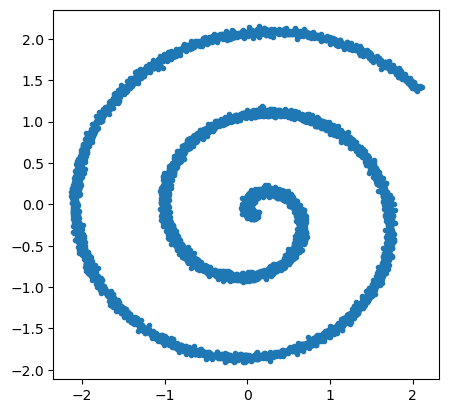

In [3]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def data_gen(length):
  t0=5
  k = 1.5
  strength = 0.03
  train_data = torch.zeros((length,2))
  train_param = torch.rand(length)*10-5
  train_data[:, 0]  = 0.2*k*(train_param[:]-t0)*torch.cos(k*(train_param[:]-t0))+strength*torch.randn(length)
  train_data[:, 1]  = 0.2*k*(train_param[:]-t0)*torch.sin(k*(train_param[:]-t0))+strength*torch.randn(length)
  return train_data, train_param

def get_pos_from_rad(rad, k=1.5, t0=5):
  tmp_arr = torch.zeros([rad.shape[0],2])
  tmp_arr[:, 0]  = 0.2*k*(rad-t0)*torch.cos(k*(rad-t0))
  tmp_arr[:, 1]  = 0.2*k*(rad-t0)*torch.sin(k*(rad-t0))
  mu = torch.mean(tmp_arr, dim=0).unsqueeze(0)
  std = torch.std(tmp_arr, dim=0).unsqueeze(0)
  tmp_arr = (tmp_arr - mu) / std
  return tmp_arr.cpu().detach().numpy()

def get_pos_from_single_rad(rad, data_mu, data_std, k=1.5, t0=5):
  tmp_arr = torch.zeros([rad.shape[0],2])
  tmp_arr[:, 0]  = 0.2*k*(rad-t0)*torch.cos(k*(rad-t0))
  tmp_arr[:, 1]  = 0.2*k*(rad-t0)*torch.sin(k*(rad-t0))
  tmp_arr = (tmp_arr - data_mu) / data_std
  return tmp_arr.cpu().detach().numpy()

def swiss_roll_eval(xy_coord, rad, **kwargs):
  data_mu = kwargs.get('data_mu')
  data_std = kwargs.get('data_std')
  if data_mu is None or data_std is None:
    raise ValueError("Both data_mu and data_std must be provided")
  true_xy = get_pos_from_single_rad(rad, data_mu, data_std)
  return torch.tensor(true_xy, device=xy_coord.device) - xy_coord

def loss_fn_vp(model, x, c, beta_min, beta_max, eps=1e-5):
  """The loss function for training score-based generative models VP SDE

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    beta_min: hyperparameter defining noise scales
    beta_max: hyperparameter defining noise scales
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x, device=x.device)
  mu = x*torch.exp(-0.25*random_t**2*(beta_max-beta_min)-0.5*random_t*beta_min)[:, None]
  std = torch.sqrt(1-torch.exp(-0.5*random_t**2*(beta_max-beta_min)-random_t*beta_min))
  perturbed_x = mu + z*std[:, None]
  score = model(perturbed_x, c, random_t)

  loss = torch.mean(torch.sum((score*std[:, None] + z)**2, dim=1))
  #loss = torch.mean(torch.sum((score + z)**2, dim=1))
  return loss

def p_losses(score_model, sde, x0):
    # compute losses (including ELBO, score-matching loss)
    t = torch.rand(x0.shape[0], device=x0.device) * (1. - 1e-5) + 1e-5
    x_perturbed, std, z = sde.forward(x0, t)
    #context_mask = torch.zeros_like(c)
    score_pred = score_model(x_perturbed, t)

    loss_dict = {}

    log_prefix = 'train' 

    # score-mathcing objective function
    score_loss = torch.sum((score_pred*std + z)**2, dim=(1))

    loss_dict.update({f'{log_prefix}/loss_score': score_loss.mean()})

    lamb = sde.g(t)**2
    loss_vlb = lamb*score_loss
    loss_vlb = loss_vlb.mean()
    loss_dict.update({f'{log_prefix}/loss_vlb': loss_vlb})

    loss = score_loss.mean()

    loss_dict.update({f'{log_prefix}/loss': loss})

    return loss, loss_dict

# calculate frechet inception distance
def fid_metric(act1, act2):
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  if np.isnan(sigma1).any() or np.isnan(sigma2).any() or np.isinf(sigma1).any() or np.isinf(sigma2).any():
    print("Invalid values detected in sigma1 or sigma2. Returning NaN for metrics.")
    return (np.nan, np.nan)
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

seed_everything(111)
data_type = 'swiss_roll' # 'circle'
#ndim = 2

train_data_length = 8192

xlim_min = -1.5
xlim_max = 2.0
ylim_min = -1.5
ylim_max = 2.0

train_data, _ = data_gen(train_data_length)
data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
data_std = torch.std(train_data, dim=0).unsqueeze(0)
train_data = (train_data - data_mu) / data_std
#train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
train_set, val_set = torch.utils.data.random_split(train_set, [1,0])

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)
#val_loader = torch.utils.data.DataLoader(
#    val_set, batch_size=batch_size, shuffle=True
#)

plt.plot(train_data[train_set.indices, 0], train_data[train_set.indices, 1], ".")
#plt.plot(train_data[val_set.indices, 0], train_data[val_set.indices, 1], ".")
#plt.xlim(xlim_min, xlim_max)
#plt.ylim(ylim_min, ylim_max)
plt.gca().set_aspect('equal', adjustable='box')

In [4]:
# denoising architecture
hidden_size = 128
hidden_layers = 6
embedding_size = 128
time_embedding = 'sinusoidal'
input_embedding = 'sinusoidal'
cond_embedding = 'sinusoidal'

# optimization
learning_rate = 1e-4
num_epochs = 500

beta_min = 1e-4 # for SDE noise [VP]
beta_max = 0.5 # for SDE noise [VP]

device='cuda'
#output_step = 50

#beta_min_values = np.logspace(-8, -2, num=7) 
beta_min_values = np.array([1e-4])
#beta_max_values = np.hstack((np.array([1]),np.linspace(10, 100, num=10)))
beta_max_values = np.array([0.5])
last_loss_values = []
fid_values = []
avg_nll_values = []
for beta_min in beta_min_values:
    for beta_max in beta_max_values:
        seed_everything(0)
        vp = uncon_VP_1D(beta_min, beta_max)

        model = MLP(
                hidden_size=hidden_size,
                hidden_layers=hidden_layers,
                emb_size=embedding_size,
                time_emb=time_embedding,
                input_emb=input_embedding).to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )

        global_step = 0
        frames = []
        loss_v = []
        loss_avg = []
        #val_loss_avg = []

        #tqdm_epoch = tqdm.notebook.trange(num_epochs)
        best_val_loss = float('inf')
        save_path = './model.pth' 
        print('training ...')
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss,_ = p_losses(model, vp, x)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
                loss_v.append(loss.item())
                loss_avg.append(avg_loss / num_items)
            # Print the averaged training loss so far.
            #if epoch % output_step == 0 or epoch == num_epochs - 1:
        torch.save(model.state_dict(), 'mdl_weights/'+str(beta_min)+'_'+str(beta_max)+'.pth')
        print('beta_max: ', beta_max, ' beta_min: ', beta_min, ' last_loss: ', avg_loss / num_items)

        last_loss = avg_loss / num_items
        vp_sampler = uncon_EulerMaruyama(1000, 1e-5, train_data_length)
        #vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
        samples, _ = vp_sampler(model, vp, train_data.shape, device)
        #samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
        samples = samples.detach().cpu().numpy()
        fid = fid_metric(samples, train_data.detach().cpu().numpy())
        inverse_scaler = 1 # dummy param
        likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
        nll = likelihood_fn(model, train_data.to(device))[0]
        avg_nll = np.mean(nll.detach().cpu().numpy())
        
        last_loss_values.append(last_loss)
        fid_values.append(fid)
        avg_nll_values.append(avg_nll)

training ...
beta_max:  0.5  beta_min:  0.0001  last_loss:  1.3948251502588391


In [5]:
import pandas as pd

results_df = pd.DataFrame({
    'beta_min': np.repeat(beta_min_values, len(beta_max_values)),
    'beta_max': np.tile(beta_max_values, len(beta_min_values)),
    'last_loss': last_loss_values,
    'fid': fid_values,
    'avg_nll': avg_nll_values
})

print(results_df)

   beta_min  beta_max  last_loss       fid   avg_nll
0    0.0001       0.5   1.394825  0.001097  0.387992


In [6]:
#results_df.to_csv("results.csv", index=False)
#results_df = pd.read_csv("results.csv")

In [7]:
vp_sampler = uncon_EulerMaruyama(1000, 1e-5, train_data_length)
vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
samples, _ = vp_sampler(model, vp, train_data.shape, device)
#samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
samples = samples.detach().cpu().numpy()

In [8]:
print(beta_min, beta_max)

0.0001 0.5


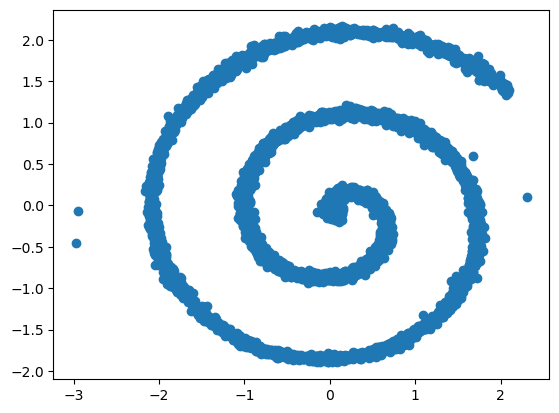

In [9]:
plt.scatter(samples[:,0], samples[:,1])
#plt.xlim((-5,5))
#plt.ylim((-5,5))